In [1]:
import config
from config import *
from dataLoader import CustomDataset

cuda:0
1.12.0+cu102




In [2]:
train_dataset = CustomDataset(config.TRAIN_DIR, config.transformations)
train_data_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)

In [3]:
class VAE(torch.nn.Module):
    def __init__(self, in_channels, latent_dim = 128, hidden_dims = None):
        super().__init__()
        if hidden_dims is None:
            hidden_dims = [32, 64, 128]

        modules = []
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.conv_encoder = nn.Sequential(*modules)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 8 * 8, 128)
        self.fc_mu = nn.Linear(128, latent_dim)

        self.fc_log_var = nn.Linear(128, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 128 * 8 * 8, )
        self.relu = nn.ReLU()

        hidden_dims.reverse()
        modules = []
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride=2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU(0.2))
            )
        modules.append(
            nn.Sequential(
                nn.ConvTranspose2d(hidden_dims[-1],
                                   3,
                                   kernel_size=3,
                                   stride=2,
                                   padding=1,
                                   output_padding=1),
                nn.BatchNorm2d(3),
                nn.Sigmoid()
            )
        )
        self.conv_decoder = nn.Sequential(*modules)

    @staticmethod
    def reparametrize(mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        sample = mu + (eps * std)
        return sample


    def forward(self, x):
        x = self.conv_encoder(x)
        x = self.flatten(x)
        hidden = self.fc1(x)
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)

        z = self.reparametrize(mu, log_var)
        z = self.fc2(z)
        z = z.view(z.shape[0],128,8,8)

        reconstruction = self.conv_decoder(z)
        return reconstruction, mu, log_var

In [4]:
def final_loss(bce_loss, mu, log_var):
    BCE = bce_loss
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

def train(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    counter = 0
    for i, data in tqdm(enumerate(dataloader), total= int(len(dataloader)/config.BATCH_SIZE)):
        counter += 1
        img_batch = data[0]
        optimizer.zero_grad()
        reconstruction, mu, log_var = model(img_batch)
        bce_loss = criterion(reconstruction, img_batch)
        loss = final_loss(bce_loss, mu, log_var)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    train_loss = running_loss / counter
    return train_loss

def vaildate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    counter = 0
    recon_images = []
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total= int(len(dataloader)/config.BATCH_SIZE)):
            counter += 1
            img_batch = data[0]
            reconstruction, mu, log_var = model(img_batch)
            bce_loss = criterion(reconstruction, img_batch)
            loss = final_loss(bce_loss, mu, log_var)
            running_loss += loss.item()
            recon_images.append(reconstruction)

    val_loss = running_loss / counter
    return val_loss, recon_images

In [5]:
model = VAE(3, 128).to(config.DEVICE)
n_epochs = 100
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss(reduction='sum')
#criterion = nn.MSELoss()

train_loss = []
valid_loss = []
for epoch in range(n_epochs):
    train_epoch_loss = train(model, train_data_loader, optimizer, criterion)
    valid_epoch_loss, _ = vaildate(model, train_data_loader, criterion)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    clear_output(wait=True)
    print(f'Epoch:{epoch+1}/{n_epochs} \t Train Loss: {train_epoch_loss:.4f} \t Val Loss: {valid_epoch_loss:.4f}')

Epoch:100/100 	 Train Loss: 212158.4312 	 Val Loss: 231144.6172


In [ ]:
torch.save(model.state_dict(), config.SAVE_MODEL_PATH + 'best_model_vae.pt')

5it [00:00, 35.54it/s]


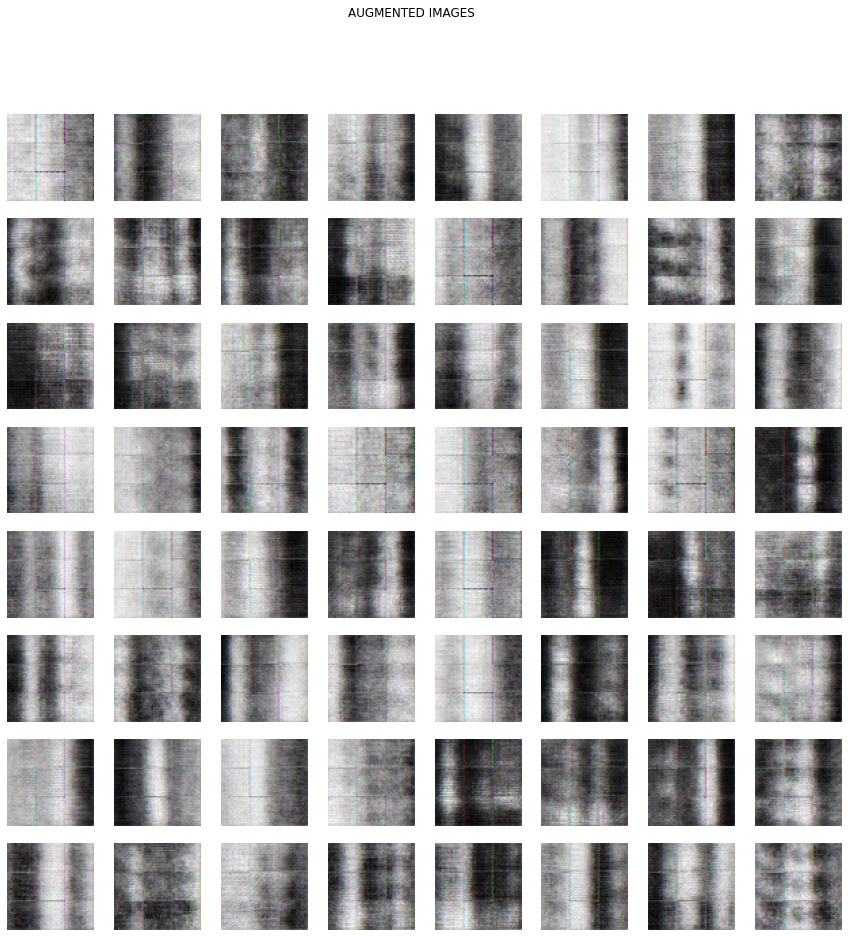

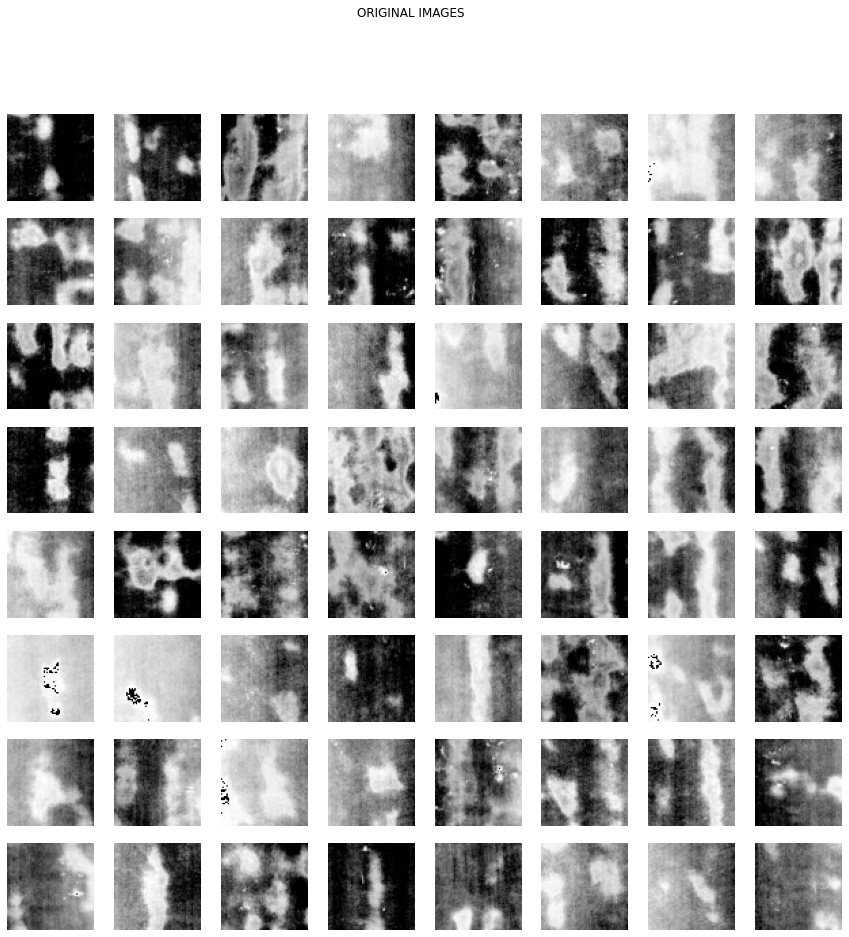

In [6]:
valid_epoch_loss, recon_images_batches = vaildate(model, train_data_loader, criterion)
recon_images = recon_images_batches[0]
imgs = recon_images.detach().cpu()
for i in range(64):
    imgs[i] = CustomDataset.renormalize(imgs[i])
imgs = imgs.numpy()
cnt = 0
fig, axs = plt.subplots(8, 8, figsize=(15, 15))
for i in range(8):
    for j in range(8):
        axs[i, j].imshow(np.reshape(imgs[cnt, :, ...], (64, 64, 3)))
        axs[i, j].axis('off')
        cnt += 1
plt.savefig('Augmented.png')
fig.suptitle('AUGMENTED IMAGES')
plt.show()

imgs = next(iter(train_data_loader))[0].detach().cpu()
for i in range(64):
    imgs[i] = CustomDataset.renormalize(imgs[i])
imgs = imgs.numpy()
cnt = 0
fig, axs = plt.subplots(8, 8, figsize=(15, 15))
for i in range(8):
    for j in range(8):
        axs[i, j].imshow(np.reshape(imgs[cnt, :, ...], (64, 64, 3)))
        axs[i, j].axis('off')
        cnt += 1
plt.savefig('Original.png')
fig.suptitle('ORIGINAL IMAGES')
plt.show()
